# Basic Exploratory Data Analysis
## Prerequisites
- Install Python 3



In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Disable the specific warning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# Load Feature File
df = pd.read_csv("../TeamSeasons.csv")

## Basic Seed Exploration

# Investigate Individual Feature Importance

In [24]:
# Import HDBSCAN
from sklearn.cluster import HDBSCAN

ValueError: 'c' argument has 1268 elements, which is inconsistent with 'x' and 'y' with size 228.

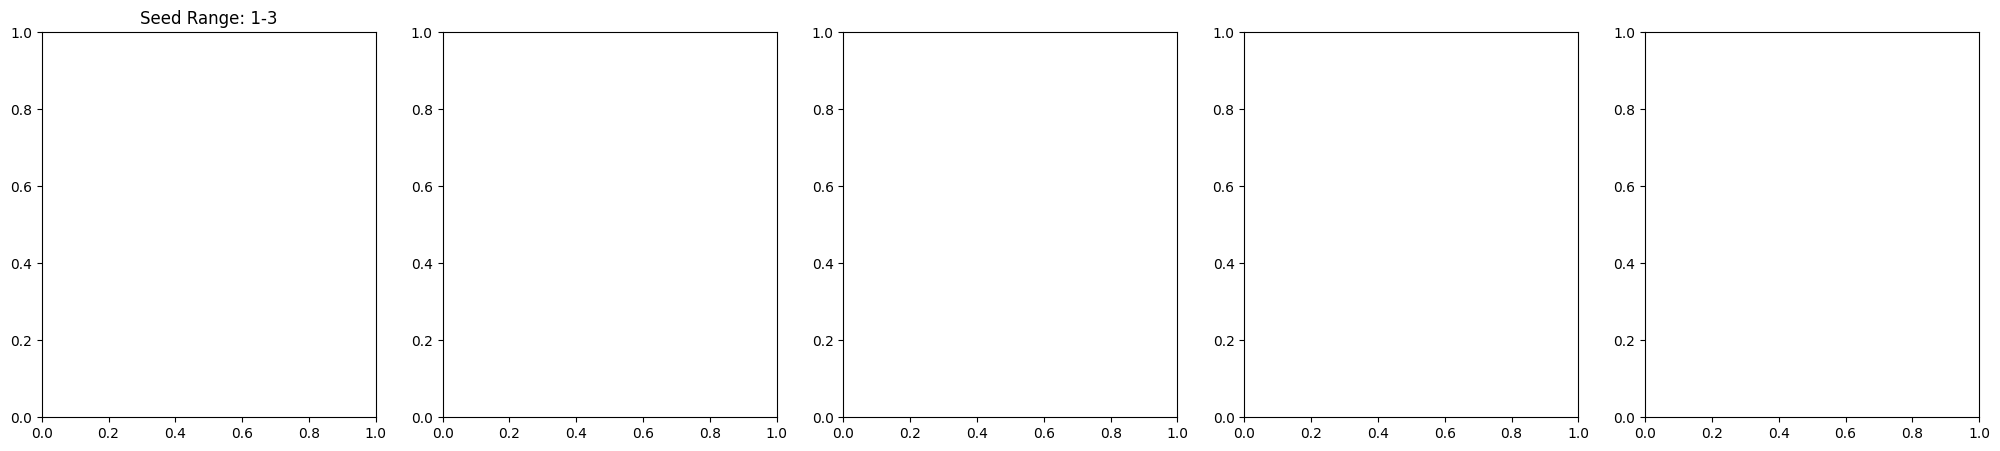

In [25]:
seed_bounds = [(1, 3), (4, 6), (7, 10), (11, 13), (14, 16)]
colors = tourney_teams["ExceedExp"].map({True: "g", False: "r"})
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax = ax.flatten()
for i, (lower, upper) in enumerate(seed_bounds):
    ax[i].set_title(f"Seed Range: {lower}-{upper}")
    seed_df = tourney_teams[(tourney_teams["Seed"] >= lower) & (tourney_teams["Seed"] <= upper)]
    # Scatter plot of AdjOE vs AdjDE with color by ExceedExpColor
    seed_df.plot(kind='scatter', x='AdjOE_mean', y='AdjDE_mean', c=colors, ax=ax[i])
    
    # Run HDBScan on the data
    hdb = HDBSCAN(min_cluster_size=20)
    # Plot the clusters
    hdb.fit(seed_df[["AdjOE_mean", "AdjDE_mean"]])
fig.tight_layout()



# Setup Datasets for Model Exploration

In [ ]:
tourney_teams["ExceedExp"].value_counts()

False    970
True     298
Name: ExceedExp, dtype: int64

In [ ]:
X_COLS = set(tourney_teams.columns.tolist()) - { "ExceedExp", "ExitRound", "ExitRoundNum", "ScaledExitRoundNum", "Seed" }

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = tourney_teams[list(X_COLS)]
X.fillna(0, inplace=True)
Y = tourney_teams["ExceedExp"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, stratify=Y, shuffle=True)
ss_train = MinMaxScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = MinMaxScaler()
X_test = ss_test.fit_transform(X_test)

ValueError: could not convert string to float: 'r'

# Methods for Feature Selection

In [ ]:
SELECT_N_FEATURES = 12

In [ ]:
# Basic Feature Selection for Classification
from sklearn.feature_selection import SelectKBest, f_classif

cls_selector = SelectKBest(f_classif, k=SELECT_N_FEATURES)
X_train_selected = cls_selector.fit_transform(X_train, Y_train)
X_test_selected = cls_selector.transform(X_test)

selected_features = X.columns[cls_selector.get_support()]
selected_features

Index(['SOS', 'AdjOE_mean', 'NE_mean', 'SOV', 'AdjNE_stdev', 'Q3_WinPct',
       'Q2_WinPct', 'NET_last', 'NE_stdev', 'FTA_mean', 'Q4_WinPct',
       'OppPoints_mean'],
      dtype='object')

In [ ]:
# Feature Selection for Regression
from sklearn.feature_selection import SelectKBest, f_regression

reg_selector = SelectKBest(f_regression, k=SELECT_N_FEATURES)
X_train_selected = reg_selector.fit_transform(X_train, Y_train)
X_test_selected = reg_selector.transform(X_test)

selected_features = X.columns[reg_selector.get_support()]
selected_features

Index(['SOS', 'AdjOE_mean', 'NE_mean', 'SOV', 'AdjNE_stdev', 'Q3_WinPct',
       'Q2_WinPct', 'NET_last', 'NE_stdev', 'FTA_mean', 'Q4_WinPct',
       'OppPoints_mean'],
      dtype='object')

In [ ]:
# L1-based Feature Selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.025, penalty="l1", dual=False, max_iter=10000).fit(X_train, Y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_selected = model.transform(X_train)

selected_features = X.columns[model.get_support()]
selected_features

Index(['OppFouls_mean', 'FTM_mean', 'NET_last', 'OppPoints_mean'], dtype='object')

In [ ]:
# Tree-based Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, Y_train)
model = SelectFromModel(clf, prefit=True)
X_train_selected = model.transform(X_train)

selected_features = X.columns[model.get_support()]
selected_features

Index(['SOS', 'OppOR_mean', 'OE_mean', 'OppFG3%_stdev', 'OE_stdev', 'NE_mean',
       'FTM_stdev', 'SOV', 'OppFG3%_mean', 'FGA3_stdev', 'Blk_stdev',
       'AdjNE_stdev', 'OppAst_mean', 'OppFGA3_stdev', 'Q3_WinPct', 'TeamID',
       'OppFG%_stdev', 'AdjDE_mean', 'FTM_mean', 'OppFT%_stdev', 'Q2_WinPct',
       'NET_last', 'TO_mean', 'DR_stdev', 'OppOR_stdev', 'OppBlk_mean',
       'FTA_stdev', 'OppFouls_stdev', 'FGM3_stdev', 'NE_stdev', 'Poss_stdev',
       'FG3%_stdev', 'FG%_mean', 'WinPct', 'OppTO_mean', 'Fouls_stdev',
       'FG%_stdev', 'AdjOE_stdev', 'FGA_mean', 'OppDR_mean', 'Q1_WinPct',
       'Stl_mean', 'OppFTA_stdev', 'FT%_stdev', 'FGM3_mean', 'FT%_mean'],
      dtype='object')

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb

models = {
    "Logistic Reg": LogisticRegression(),
    "Ridge": RidgeClassifier(alpha=0.5),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel="poly", degree=3, C=0.1, gamma="auto", max_iter=100000000),
    "LinearSVC": LinearSVC(max_iter=1000000),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier()
}
model_res = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall"])
for model_name, model in models.items():
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    model_res = model_res.append({
        "Model": model_name,
        "Accuracy":  accuracy_score(predictions, Y_test),
        "Precision": precision_score(predictions, Y_test),
        "Recall":    recall_score(predictions, Y_test, zero_division="warn")
    }, ignore_index=True)
print(model_res)


/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           Model  Accuracy  Precision    Recall
0   Logistic Reg  0.696335   0.133333  0.240000
1          Ridge  0.712042   0.088889  0.222222
2  Random Forest  0.759162   0.111111  0.454545
3            SVM  0.764398   0.000000  0.000000
4      LinearSVC  0.712042   0.133333  0.272727
5    Naive Bayes  0.612565   0.644444  0.333333
6            KNN  0.696335   0.088889  0.190476
7  Decision Tree  0.465969   0.333333  0.172414
8        XGBoost  0.717277   0.111111  0.263158


# Naive Bayes Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(models["Naive Bayes"], X_test, Y_test)

nb_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": imps.importances_mean,
    "Std": imps.importances_std
})
nb_importances = nb_importances.sort_values("Importance", ascending=False)
nb_importances

,Feature,Importance,Std
75,FTA_mean,0.005236,0.006623
59,OppTO_stdev,0.005236,0.003311
76,Q4_WinPct,0.004188,0.014585
73,FG%_stdev,0.003141,0.002565
54,FGM3_stdev,0.002094,0.004188
...,...,...,...
83,Stl_mean,-0.014660,0.006106
5,OE_mean,-0.015707,0.003311
69,OppTO_mean,-0.015707,0.003311
38,Q2_WinPct,-0.016754,0.006946


## Looking at XGB Boost Feature Importance

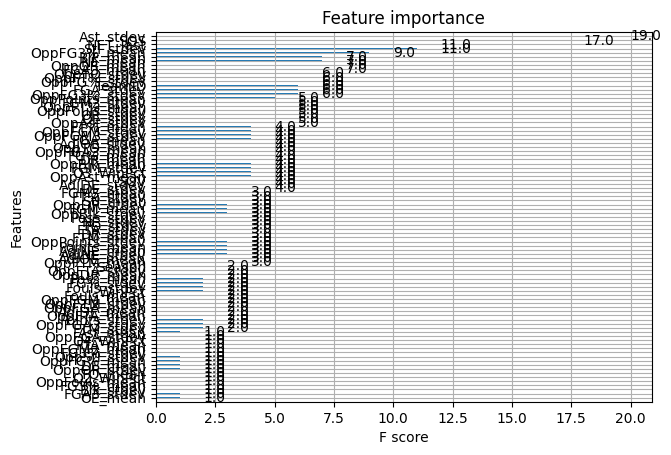

In [ ]:
# XGBoost Feature Importance
dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=X.columns.tolist())
xgb.plot_importance(xgb.train({}, dtrain))
plt.show()

# Predicting Exit Round with Different Basic Regression Models

In [ ]:
# Scale features per column
X_scaled = StandardScaler().fit_transform(X)
# ScaledExitRoundNum
Y_sern = tourney_teams["ScaledExitRoundNum"]


In [ ]:
# Predict ExitRoundNum with XGBoost
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

reg_models = [
    ("XGBReg", XGBRegressor()),
    ("linear", LinearRegression()),
    ("SGD", SGDRegressor())
]
reg_model_res = pd.DataFrame(columns=["Model", "MAE", "MAE_std"])
for model_name, model in reg_models:
    score = cross_val_score(model, X_scaled, Y_sern, cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1))
    reg_model_res = reg_model_res.append({
        "Model": model_name,
        "MAE": score.mean(),
        "MAE_std": score.std()
    }, ignore_index=True)
reg_model_res

/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 117, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/base.py", line 723, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 911, in r2_score
    y_typ

,Model,MAE,MAE_std
0,XGBReg,NaN,NaN
1,linear,NaN,NaN
2,SGD,NaN,NaN
